In [4]:
import os
import json
import dotenv

In [2]:
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dialogue2graph import metrics
from dialogue2graph.pipelines.core.graph import Graph
from dialogue2graph.pipelines.model_storage import ModelStorage
from dialogue2graph.pipelines.helpers.parse_data import PipelineRawDataType

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(
2025-04-23 06:46:53,877 - datasets - INFO - PyTorch version 2.6.0 available.


In [2]:
dotenv.load_dotenv()

True

In [21]:
from pathlib import Path
Path("data").absolute().as_posix()

'/data/home/peshkichev/projects/chatsky-llm-autoconfig/experiments/exp2025_03_20_d2g_pipeline/exp2025_03_20_d2g_pipeline/data'

In [6]:
ms = ModelStorage()

In [8]:
from dialogue2graph.datasets.complex_dialogues import generation

In [ ]:
ms.save("model_storage.yml")

In [ ]:
ms.load("model_storage.yml")

In [29]:
sampler = generation.RecursiveDialogueSampler()

In [27]:
with open("transfer_2.json") as f:
    data = json.load(f)

In [ ]:
sampler.invoke(Graph(data["true_graph"]), ms.storage["grouping_llm"].model, 15)

In [ ]:
ms

### D2G Light pipeline

In [10]:
from dialogue2graph.pipelines.d2g_light.pipeline import D2GLightPipeline

pipeline = D2GLightPipeline(
    name="d2g_light",
    model_storage=ms,
)

2025-04-23 06:53:14,442 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - WARNING - Key 'd2g_light_filling_llm:v1' already exists in storage with same config. Skipping.
2025-04-23 06:53:14,443 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - WARNING - Key 'd2g_light_formatting_llm:v1' already exists in storage with same config. Skipping.
2025-04-23 06:53:14,444 - /data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/model_storage.py - WARNING - Key 'd2g_light_sim_model:v1' already exists in storage with same config. Skipping.


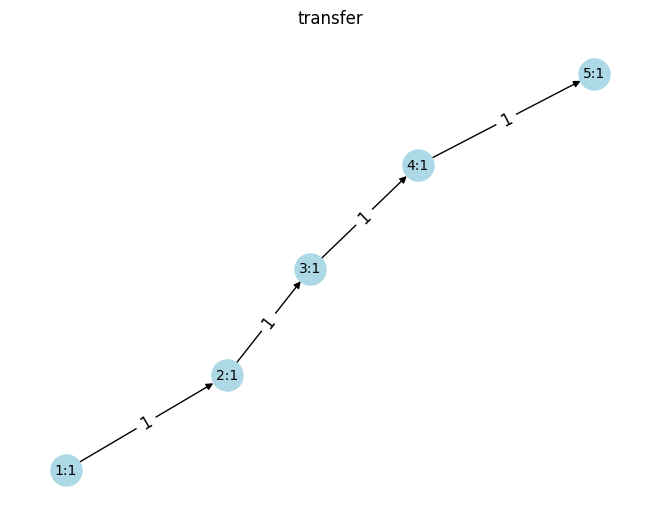

In [12]:
data = [
    {"text": "Hey there! How can I help you today?", "participant": "assistant"},
    {"text": "I need to book a ride to the airport.", "participant": "user"},
    {
        "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
        "participant": "assistant",
    },
    {"text": "Do you have any other options?", "participant": "user"},
    {
        "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
        "participant": "assistant",
    },
    {"text": "No, I'll manage on my own.", "participant": "user"},
    {"text": "No worries! Feel free to reach out anytime.", "participant": "assistant"},
    {"text": "Alright, thanks anyway.", "participant": "user"},
    {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(ms, "d2g_light_sim_model:v1", raw_data)
graph.visualise_short("transfer")

In [ ]:
graph.graph_dict

In [ ]:
data = [
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "Actually, never mind.", "participant": "user"},
        {
            "text": "Alright, let me know if you need help later. Have a great day!",
            "participant": "assistant",
        },
        {"text": "Okay, have a great day!", "participant": "user"},
        {"text": "Glad to help! Safe travels.", "participant": "assistant"},
    ],
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "No, I'll manage on my own.", "participant": "user"},
        {
            "text": "No worries! Feel free to reach out anytime.",
            "participant": "assistant",
        },
        {"text": "Alright, thanks anyway.", "participant": "user"},
        {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
    ],
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
graph.graph_dict

In [ ]:
data = [
    {
        "messages": [
            {
                "text": "Hey there! How can I help you today?",
                "participant": "assistant",
            },
            {"text": "I need to book a ride to the airport.", "participant": "user"},
            {
                "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
                "participant": "assistant",
            },
            {"text": "Do you have any other options?", "participant": "user"},
            {
                "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
                "participant": "assistant",
            },
            {"text": "No, I'll manage on my own.", "participant": "user"},
            {
                "text": "No worries! Feel free to reach out anytime.",
                "participant": "assistant",
            },
            {"text": "Alright, thanks anyway.", "participant": "user"},
            {
                "text": "You're welcome! Have a fantastic trip!",
                "participant": "assistant",
            },
        ]
    }
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data

In [ ]:
graph.graph_dict

In [ ]:
gr = Graph(data["true_graph"])
gr.graph_dict

In [ ]:
report

In [ ]:
graph.graph_dict

In [ ]:
with open("transfer_2.json") as f:
    data = json.load(f)

raw_data = PipelineRawDataType(dialogs=data["dialogs"])
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
report

2025-04-22 07:41:35,498 - dialogue2graph.metrics.no_llm_metrics.metrics - INFO - Graph has all the dialogues


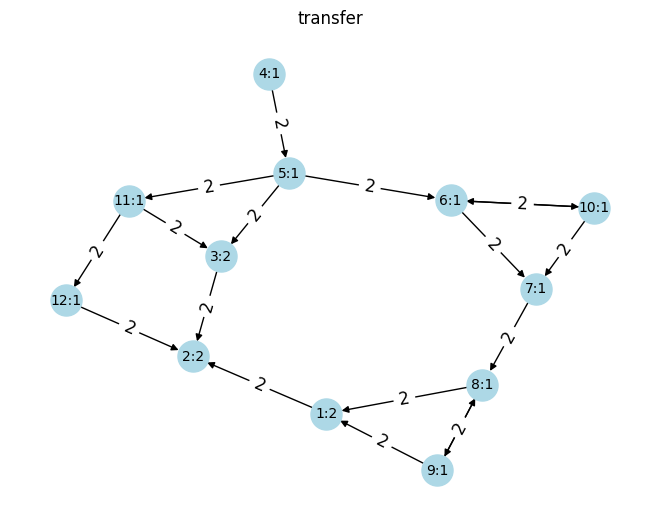

In [12]:
with open("transfer_2.json") as f:
    data = json.load(f)

raw_data = PipelineRawDataType(dialogs=data["dialogs"], true_graph=data["true_graph"])
graph, report = pipeline.invoke(ms, "sim_model", raw_data)
graph.visualise_short("transfer")

In [ ]:
report

In [ ]:
raw_data = PipelineRawDataType(dialogs="transfer_2.json", true_graph="transfer_2.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
report

In [ ]:
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

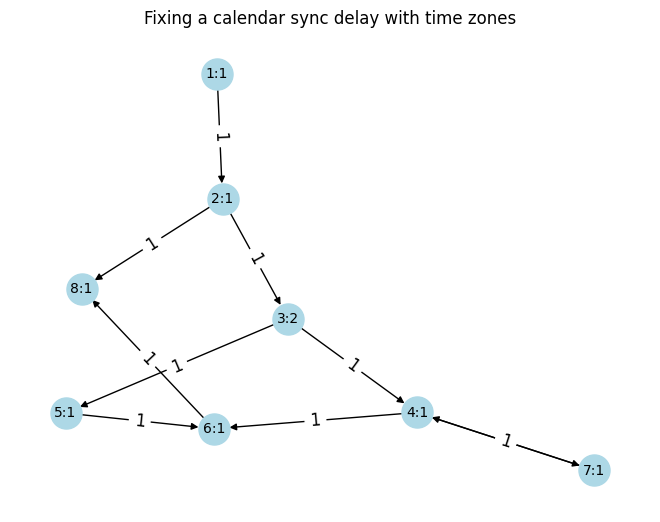

In [9]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data["true_graph"]).visualise_short(
    "Fixing a calendar sync delay with time zones"
)

In [ ]:
raw_data = PipelineRawDataType(dialogs="test_graph_1.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("Fixing a calendar sync delay with time zones")

In [12]:
raw_data = PipelineRawDataType(dialogs=data["dialogs"], true_graph=data["true_graph"])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

2025-04-21 13:01:45,585 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/embeddings "HTTP/1.1 200 OK"
2025-04-21 13:01:45,940 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/embeddings "HTTP/1.1 200 OK"
2025-04-21 13:01:46,289 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/embeddings "HTTP/1.1 200 OK"
2025-04-21 13:01:46,594 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/embeddings "HTTP/1.1 200 OK"
2025-04-21 13:01:46,930 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/embeddings "HTTP/1.1 200 OK"
2025-04-21 13:01:47,276 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/embeddings "HTTP/1.1 200 OK"
2025-04-21 13:01:47,736 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/embeddings "HTTP/1.1 200 OK"
2025-04-21 13:01:48,

PipelineReport(service='d2g_light', properties={'time': 17.50765895843506, 'simple_graph_comparison': True, 'complex_graph_comparison': {'similarity_avg': 0.9790905117988586, 'matched_triplets': [{'original_triplet': {'start': {'type': 'node', 'id': 1, 'utterances': ['Could you verify that the time zone settings are properly configured on your devices?', 'Have you checked if your time zone settings are correct on all your devices?']}, 'middle': {'type': 'edge', 'id': (1, 4), 'utterances': ['alright, please guide me through the steps.']}, 'end': {'type': 'node', 'id': 4, 'utterances': ['Sure, let me guide you through adjusting your time zone settings.']}}, 'generated_triplet': {'start': {'type': 'node', 'id': 3, 'utterances': ['Could you verify that the time zone settings are properly configured on your devices?', 'Have you checked if your time zone settings are correct on all your devices?']}, 'middle': {'type': 'edge', 'id': (3, 4), 'utterances': ['Alright, please guide me through the

In [13]:
with open("test_metrics_data.json", encoding="utf-8") as f:
    data_2 = json.load(f)

In [14]:
from dialogue2graph.metrics.llm_metrics import compare_graphs

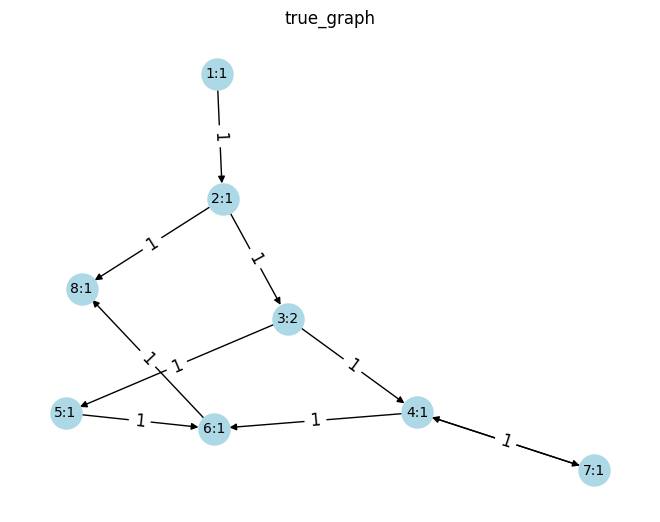

In [15]:
Graph(data_2[0]["graph"]).visualise_short("true_graph")

In [21]:
compare_graphs(
    Graph(data_2[1]["graph"]), graph
)

{'value': False, 'description': 'Numbers of nodes do not match: 8 != 7'}

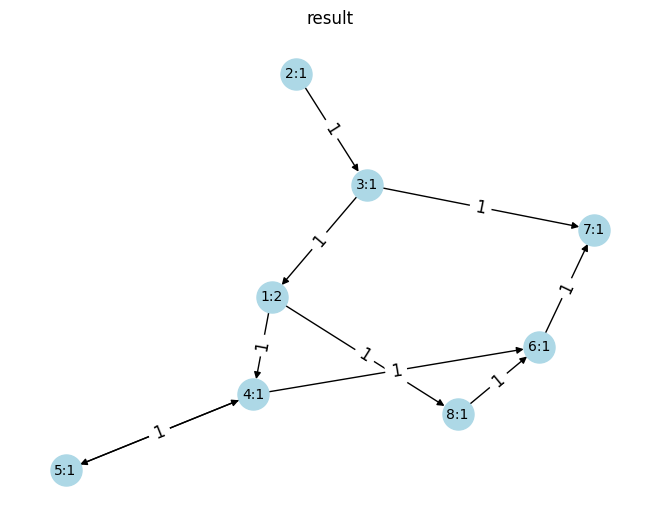

In [17]:
graph.visualise_short("result")

In [13]:
with open("test_pipelines_data.json", encoding="utf-8") as f:
    data_2 = json.load(f)
raw_data = PipelineRawDataType(
    dialogs=data_2[2]["dialogues"], true_graph=data_2[1]["graph"]
)
graph, report = pipeline.invoke(ms, "d2g_light_sim_model:v1", raw_data, enable_evals=True)
report

2025-04-23 06:56:02,365 - httpx - INFO - HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 06:56:02,428 - dialogue2graph.metrics.no_llm_metrics.metrics - INFO - Graph has all the dialogues


PipelineReport(service='d2g_light', properties={'time': 11.86310863494873, 'simple_graph_comparison': False, 'complex_graph_comparison': {'similarity_avg': 0.931039571762085, 'matched_triplets': [{'original_triplet': {'start': {'type': 'node', 'id': 10, 'utterances': ['Hello! How can I assist you with your calendar today?']}, 'middle': {'type': 'edge', 'id': (10, 11), 'utterances': ["I'm having trouble with my calendar not syncing properly."]}, 'end': {'type': 'node', 'id': 11, 'utterances': ["I'm sorry to hear you're experiencing a sync delay. Can you tell me more about the issue?"]}}, 'generated_triplet': {'start': {'type': 'node', 'id': 1, 'utterances': ['Could you verify that the time zone settings are properly configured on your devices?']}, 'middle': {'type': 'edge', 'id': (1, 7), 'utterances': ['time zone settings are correct, but the issue persists.']}, 'end': {'type': 'node', 'id': 7, 'utterances': ['If time zone settings are correct, we can try refreshing the calendar app or 

In [ ]:
import os
from datasets import load_dataset

In [43]:
dataset = load_dataset("DeepPavlov/d2g_generated_augmented", token=os.getenv("HUGGINGFACE_TOKEN"))
data = dataset['train'][0]
data['dialogues'][0]

{'id': 'Responding to DMs on Instagram/Facebook._1_0',
 'messages': [{'participant': 'assistant',
   'text': 'Hi there! How can I assist you today?'},
  {'participant': 'user', 'text': 'I want to place an order.'},
  {'participant': 'assistant',
   'text': 'Great! What product are you interested in?'},
  {'participant': 'user', 'text': 'I’d like a t-shirt.'},
  {'participant': 'assistant', 'text': 'What size would you like?'},
  {'participant': 'user', 'text': 'Medium, please.'},
  {'participant': 'assistant', 'text': 'Would you like that in red or blue?'},
  {'participant': 'user', 'text': 'Red, please.'},
  {'participant': 'assistant',
   'text': 'Perfect! Can I have your shipping address?'},
  {'participant': 'user', 'text': 'Sure, it’s 123 Main St.'},
  {'participant': 'assistant',
   'text': 'Thank you! Your order has been placed. Is there anything else I can help you with?'},
  {'participant': 'user', 'text': 'Actually, can I change my order?'},
  {'participant': 'assistant',
   

In [64]:
for l in list_of_files:
    print (l)

In [74]:
latest_file

PosixPath('/data/home/peshkichev/projects/chatsky-llm-autoconfig/tests/metrics/d2g_light_22.04.2025_1.json')

In [72]:
from pathlib import Path
import os

list_of_files = Path('/data/home/peshkichev/projects/chatsky-llm-autoconfig/tests/metrics').glob('d2g_light*.json') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=lambda x: x.stat().st_ctime)
# latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

/data/home/peshkichev/projects/chatsky-llm-autoconfig/tests/metrics/d2g_light_22.04.2025_1.json


In [51]:
list_of_files

[]

In [46]:
raw_data = PipelineRawDataType(
    dialogs=data["augmented_dialogues"][0], true_graph=data["graph"]
)
graph, report = pipeline.invoke(ms, "d2g_light_sim_model:v1", raw_data, enable_evals=True)
report

2025-04-22 13:10:50,372 - dialogue2graph.metrics.no_llm_metrics.metrics - INFO - Graph has all the dialogues


PipelineReport(service='d2g_light', properties={'time': 2.354783296585083, 'simple_graph_comparison': False, 'complex_graph_comparison': {'similarity_avg': 0.9247153401374817, 'matched_triplets': [{'original_triplet': {'start': {'type': 'node', 'id': 1, 'utterances': ['Hi! What can I do for you today?', 'Hi there! How can I assist you today?', 'Hey! How may I help you today?', 'Hey there! What assistance do you need today?', 'Hello! What can I do for you today?', 'Hey there! How may I assist you?', 'Hello! How can I help you today?', 'Hey there! What can I do for you today?', 'Hi! What assistance do you need today?', 'Hi! Is there something I can assist you with today?', 'Hello! What can I help you with today?', 'Hi! What do you need help with today?', 'Hey there! How may I assist you today?']}, 'middle': {'type': 'edge', 'id': (1, 2), 'utterances': ["I'm looking to place an order.", 'I’d like to place an order.', 'I want to make an order.', 'I want to order something.', 'I’d like to m

In [47]:
compare_graphs(
    Graph(data["graph"]), graph
)

{'value': False, 'description': 'Numbers of nodes do not match: 9 != 12'}

In [39]:
data['graph']

{'edges': [{'source': 1,
   'target': 2,
   'utterances': ["I'm looking to place an order.",
    'I’d like to place an order.',
    'I want to make an order.',
    'I want to order something.',
    'I’d like to make an order.',
    'I want to place an order.',
    "I'm looking to order something.",
    'I want to make a purchase.']},
  {'source': 1,
   'target': 3,
   'utterances': ['I would like to get some information on your offerings.',
    'Could you provide me with some details about your products?',
    "I'd like some product information.",
    "I'm interested in learning more about your products.",
    'Could you provide me with details about your products?',
    'I would like some details on your product offerings.']},
  {'source': 1,
   'target': 4,
   'utterances': ["That's fine, thank you.",
    "It's all good, thanks anyway.",
    'No worries, I appreciate it.',
    'Never mind, thanks.']},
  {'source': 2,
   'target': 5,
   'utterances': ['I’m back to wanting a t-shirt.',

In [37]:
dataset = load_dataset("DeepPavlov/d2g_generated", token=os.getenv("HUGGINGFACE_TOKEN"))
data = dataset['train'][0]
data['dialogues'][0]

{'id': 'Responding to DMs on Instagram/Facebook._1_0',
 'messages': [{'participant': 'assistant',
   'text': 'Hi there! How can I assist you today?'},
  {'participant': 'user', 'text': 'I want to place an order.'},
  {'participant': 'assistant',
   'text': 'Great! What product are you interested in?'},
  {'participant': 'user', 'text': 'I’d like a t-shirt.'},
  {'participant': 'assistant', 'text': 'What size would you like?'},
  {'participant': 'user', 'text': 'Medium, please.'},
  {'participant': 'assistant', 'text': 'Would you like that in red or blue?'},
  {'participant': 'user', 'text': 'Red, please.'},
  {'participant': 'assistant',
   'text': 'Perfect! Can I have your shipping address?'},
  {'participant': 'user', 'text': 'Sure, it’s 123 Main St.'},
  {'participant': 'assistant',
   'text': 'Thank you! Your order has been placed. Is there anything else I can help you with?'},
  {'participant': 'user', 'text': 'Actually, can I change my order?'},
  {'participant': 'assistant',
   

In [31]:
data = dataset['train'][0]
dialogs = data['dialogues'][0]['messages']
graph = data['graph']
raw_data = PipelineRawDataType(
    dialogs=dialogs, true_graph=graph
)

In [32]:
data['graph']

{'edges': [{'source': 1,
   'target': 2,
   'utterances': ['I want to place an order.']},
  {'source': 1,
   'target': 3,
   'utterances': ["I'd like some product information."]},
  {'source': 1, 'target': 4, 'utterances': ['Never mind, thanks.']},
  {'source': 2, 'target': 5, 'utterances': ['I’d like a t-shirt.']},
  {'source': 5, 'target': 6, 'utterances': ['Medium, please.']},
  {'source': 6, 'target': 7, 'utterances': ['Red, please.']},
  {'source': 7, 'target': 8, 'utterances': ['Sure, it’s 123 Main St.']},
  {'source': 8,
   'target': 9,
   'utterances': ['Actually, can I change my order?',
    'Actually, I need to modify my order.']},
  {'source': 8, 'target': 4, 'utterances': ["No, that's all. Thank you."]},
  {'source': 9, 'target': 5, 'utterances': ['I want a large size.']},
  {'source': 6,
   'target': 2,
   'utterances': ['Actually, can I change my product?']}],
 'nodes': [{'id': 1,
   'is_start': True,
   'label': 'greeting',
   'utterances': ['Hi there! How can I assist y

In [27]:
dialogs

[{'participant': 'assistant', 'text': 'Hello! How can I help you today?'},
 {'participant': 'user', 'text': 'I’d like to place an order.'},
 {'participant': 'assistant',
  'text': 'Awesome! Which product are you interested in?'},
 {'participant': 'user', 'text': 'I would like a t-shirt.'},
 {'participant': 'assistant', 'text': 'What size do you prefer?'},
 {'participant': 'user', 'text': "I'd like a medium size, please."},
 {'participant': 'assistant', 'text': 'Do you want that in red or blue?'},
 {'participant': 'user', 'text': 'I prefer red, please.'},
 {'participant': 'assistant',
  'text': 'Great choice! Could you provide your shipping address?'},
 {'participant': 'user', 'text': 'Sure, it’s 123 Main Street.'},
 {'participant': 'assistant',
  'text': 'Thanks! Your order has been successfully placed. Is there anything else you need?'},
 {'participant': 'user', 'text': 'Actually, I’d like to modify my order.'},
 {'participant': 'assistant',
  'text': 'Absolutely! What changes would y

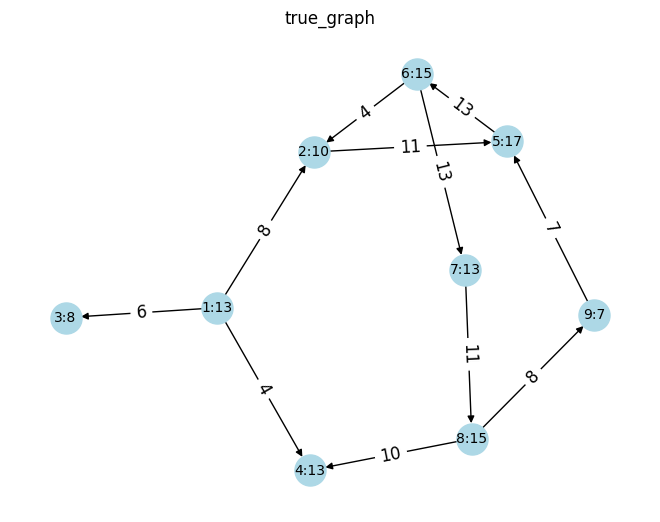

In [26]:
Graph(graph).visualise_short("true_graph")

In [19]:
from dialogue2graph.pipelines.report import PipelineReport

In [21]:
report.properties['complex_graph_comparison']['matched_triplets'][0]

{'original_triplet': {'start': {'type': 'node',
   'id': 1,
   'utterances': ['Could you verify that the time zone settings are properly configured on your devices?']},
  'middle': {'type': 'edge',
   'id': (1, 2),
   'utterances': ['alright, please guide me through the steps.']},
  'end': {'type': 'node',
   'id': 2,
   'utterances': ['Sure, let me guide you through adjusting your time zone settings.']}},
 'generated_triplet': {'start': {'type': 'node',
   'id': 3,
   'utterances': ['Could you verify that the time zone settings are properly configured on your devices?',
    'Have you checked if your time zone settings are correct on all your devices?']},
  'middle': {'type': 'edge',
   'id': (3, 4),
   'utterances': ['Alright, please guide me through the steps.']},
  'end': {'type': 'node',
   'id': 4,
   'utterances': ['Sure, let me guide you through adjusting your time zone settings.']}},
 'similarity_score': 0.9923478960990906}

In [22]:
len(report.properties['complex_graph_comparison']['matched_triplets'])

19

### D2G LLM pipeline

In [64]:
from dialogue2graph.pipelines.d2g_llm.pipeline import D2GLLMPipeline

pipeline = D2GLLMPipeline(
    name="d2g_llm",
    model_storage=ms,
    grouping_llm="grouping_llm",
    filling_llm="filling_llm",
    formatting_llm="formatting_llm",
    sim_model="sim_model",
    step2_evals=metrics.DGEvalBase,
    end_evals=metrics.DGEvalBase,
)

In [ ]:
raw_data = PipelineRawDataType(dialogs="transfer.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    {"text": "Hey there! How can I help you today?", "participant": "assistant"},
    {"text": "I need to book a ride to the airport.", "participant": "user"},
    {
        "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
        "participant": "assistant",
    },
    {"text": "Do you have any other options?", "participant": "user"},
    {
        "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
        "participant": "assistant",
    },
    {"text": "No, I'll manage on my own.", "participant": "user"},
    {"text": "No worries! Feel free to reach out anytime.", "participant": "assistant"},
    {"text": "Alright, thanks anyway.", "participant": "user"},
    {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "Actually, never mind.", "participant": "user"},
        {
            "text": "Alright, let me know if you need help later. Have a great day!",
            "participant": "assistant",
        },
        {"text": "Okay, have a great day!", "participant": "user"},
        {"text": "Glad to help! Safe travels.", "participant": "assistant"},
    ],
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "No, I'll manage on my own.", "participant": "user"},
        {
            "text": "No worries! Feel free to reach out anytime.",
            "participant": "assistant",
        },
        {"text": "Alright, thanks anyway.", "participant": "user"},
        {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
    ],
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    {
        "messages": [
            {
                "text": "Hey there! How can I help you today?",
                "participant": "assistant",
            },
            {"text": "I need to book a ride to the airport.", "participant": "user"},
            {
                "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
                "participant": "assistant",
            },
            {"text": "Do you have any other options?", "participant": "user"},
            {
                "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
                "participant": "assistant",
            },
            {"text": "No, I'll manage on my own.", "participant": "user"},
            {
                "text": "No worries! Feel free to reach out anytime.",
                "participant": "assistant",
            },
            {"text": "Alright, thanks anyway.", "participant": "user"},
            {
                "text": "You're welcome! Have a fantastic trip!",
                "participant": "assistant",
            },
        ]
    }
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
with open("transfer.json") as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data["dialogs"], true_graph=data["true_graph"])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

### D2G LLM extender

In [ ]:
from dialogue2graph.pipelines.d2g_extender.pipeline import D2GExtenderPipeline

pipeline = D2GExtenderPipeline(
    name="d2g_ext",
    model_storage=ms,
    extending_llm="filling_llm",
    filling_llm="filling_llm",
    formatting_llm="formatting_llm",
    sim_model="sim_model",
    step1_evals=metrics.PreDGEvalBase,
    extender_evals=metrics.PreDGEvalBase,
    step2_evals=metrics.DGEvalBase,
    end_evals=metrics.DGEvalBase,
)

In [ ]:
data = [
    {"text": "Hey there! How can I help you today?", "participant": "assistant"},
    {"text": "I need to book a ride to the airport.", "participant": "user"},
    {
        "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
        "participant": "assistant",
    },
    {"text": "Do you have any other options?", "participant": "user"},
    {
        "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
        "participant": "assistant",
    },
    {"text": "No, I'll manage on my own.", "participant": "user"},
    {"text": "No worries! Feel free to reach out anytime.", "participant": "assistant"},
    {"text": "Alright, thanks anyway.", "participant": "user"},
    {"text": "You're welcome! Have a fantastic trip!", "participant": "assistant"},
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    [
        {"text": "Hey there! How can I help you today?", "participant": "assistant"},
        {"text": "I need to book a ride to the airport.", "participant": "user"},
        {
            "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
            "participant": "assistant",
        },
        {"text": "Do you have any other options?", "participant": "user"},
        {
            "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
            "participant": "assistant",
        },
        {"text": "Actually, never mind.", "participant": "user"},
        {
            "text": "Alright, let me know if you need help later. Have a great day!",
            "participant": "assistant",
        },
        {"text": "Okay, have a great day!", "participant": "user"},
        {"text": "Glad to help! Safe travels.", "participant": "assistant"},
    ]
]
raw_data = PipelineRawDataType(dialogs=data, supported_graph=graph.graph_dict)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [
    {
        "messages": [
            {
                "text": "Hey there! How can I help you today?",
                "participant": "assistant",
            },
            {"text": "I need to book a ride to the airport.", "participant": "user"},
            {
                "text": "Sure! I can help with that. When is your flight, and where are you departing from?",
                "participant": "assistant",
            },
            {"text": "Do you have any other options?", "participant": "user"},
            {
                "text": "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
                "participant": "assistant",
            },
            {"text": "No, I'll manage on my own.", "participant": "user"},
            {
                "text": "No worries! Feel free to reach out anytime.",
                "participant": "assistant",
            },
            {"text": "Alright, thanks anyway.", "participant": "user"},
            {
                "text": "You're welcome! Have a fantastic trip!",
                "participant": "assistant",
            },
        ]
    }
]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
Graph(data["true_graph"]).graph_dict

In [ ]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data["true_graph"]).visualise_short(
    "Fixing a calendar sync delay with time zones"
)

In [ ]:
raw_data = PipelineRawDataType(dialogs=data["dialogs"], true_graph=data["true_graph"])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

In [ ]:
graph.graph_dict

In [ ]:
graph.visualise_short("Fixing a calendar sync delay with time zones")

In [10]:
with open("test_metrics_data.json", encoding="utf-8") as f:
    data_2 = json.load(f)

In [ ]:
data_2[2]

In [ ]:
raw_data = PipelineRawDataType(
    dialogs=data_2[2]["dialogues"], true_graph=data["true_graph"]
)
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

In [ ]:
raw_data = PipelineRawDataType(
    dialogs=data_2[2]["dialogues"], true_graph=data_2[2]["graph"]
)
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

In [7]:
from datasets import load_dataset

In [8]:
dataset = load_dataset(
    "DeepPavlov/d2g_generated_augmented", token=os.getenv("HUGGINGFACE_TOKEN")
)

In [9]:
len(dataset['train'])

376